### 스마트 냉장고
* 데이터 셋 : 과채류 30 종류
* 피쳐/속성 : 그림 파일
* 타겟/라벨 : 폴더명
* 학습-방법 : 지도학습 > 분류 > 다중분류
* 알고리즘 : 
* 프레임워크 : Pytorch

[1] 모듈 로딩 및 데이터 준비
<hr>

In [61]:
# ---------------------------------------------------------------------
# 모델링 관련 모듈 로딩
# ---------------------------------------------------------------------
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchinfo import summary
from torch.utils.data import random_split

from torchmetrics.classification import accuracy
from torchmetrics.classification import MulticlassF1Score, MulticlassAccuracy, MulticlassConfusionMatrix
import torch.optim.lr_scheduler as lr_scheduler

import torchvision.models as models

# ---------------------------------------------------------------------
# 데이터 분석 관련 모듈 로딩
# ---------------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------
# 이미지 관련 모듈 로딩
# ---------------------------------------------------------------------
import cv2
from PIL import Image
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import v2

# ---------------------------------------------------------------------
# 기타 모듈 로딩
# ---------------------------------------------------------------------
import time
import os

# 활용 패키지 버전 체크
print(f'torch Ver.:{torch.__version__}')
print(f'pandas Ver.:{pd.__version__}')
print(f'numpy Ver.:{np.__version__}')

torch Ver.:2.4.1
pandas Ver.:2.0.3
numpy Ver.:1.24.3


In [62]:
# DEVICE 설정
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

* 이미지 데이터셋 생성
<hr>

In [63]:
# 이미지 전처리(tranform) 정의
transConvert = transforms.Compose([transforms.Resize([256]), transforms.CenterCrop(224),transforms.ToTensor(),
                           transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
# transConvert = transforms.Compose([
#                                 transforms.Resize([236]),
#                                 transforms.CenterCrop(224),
#                                 transforms.ToTensor(),
#                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# ### 데이터 로딩
# # 민하
# class Custommodel(nn.Module):
#     def __init__(self):
#         super(Custommodel, self).__init__()
#         self.features = convnext_tiny.features
#         self.avgpool = convnext_tiny.avgpool
#         self.classifier = convnext_tiny.classifier
#         self.fc = nn.Sequential(
#                 nn.ReLU(),
#                 nn.Linear(1000, 500),
#                 nn.Dropout(0.25),
#                 nn.ReLU(),
#                 nn.Linear(500, 250),
#                 nn.Dropout(0.25),
#                 nn.ReLU(),
#                 nn.Linear(250, 1)
#         )

#     def forward(self, x):
#         x = self.features(x)
#         x = self.avgpool(x)
#         x = self.classifier(x)
#         x = self.fc(x) 
    
#         return F.sigmoid(x)

In [64]:
TRAIN_PATH = r'C:\Users\KDP-14\Desktop\VSCode\LocalData\self_project_image\train'
TEST_PATH = r'C:\Users\KDP-14\Desktop\VSCode\LocalData\self_project_image\test'

In [65]:
# 이미지 데이터셋 생성
trianDS = ImageFolder(root=TRAIN_PATH, transform=transConvert)
testDS = ImageFolder(root=TEST_PATH, transform=transConvert)

In [66]:
print(f'trainDS type => {type(trianDS)} || testDS type => {type(testDS)}')

trainDS type => <class 'torchvision.datasets.folder.ImageFolder'> || testDS type => <class 'torchvision.datasets.folder.ImageFolder'>


In [67]:
print(f'trianDS.classes       : {trianDS.classes}')
print(f'trianDS.class_to_idx  : {trianDS.class_to_idx}')
print(f'trianDS.targets       : {trianDS.targets}')
for img in trianDS.imgs:
    print(f'trianDS.imgs       : {img}')
    break

trianDS.classes       : ['apple', 'banana', 'beetroot', 'bell_pepper', 'cabbage', 'carrot', 'cauliflower', 'chilli_pepper', 'cucumber', 'eggplant', 'garlic', 'ginger', 'grapes', 'kiwi', 'lemon', 'lettuce', 'mango', 'onion', 'orange', 'pear', 'peas', 'pineapple', 'pomegranate', 'potato', 'radish', 'spinach', 'sweetpotato', 'tomato', 'watermelon']
trianDS.class_to_idx  : {'apple': 0, 'banana': 1, 'beetroot': 2, 'bell_pepper': 3, 'cabbage': 4, 'carrot': 5, 'cauliflower': 6, 'chilli_pepper': 7, 'cucumber': 8, 'eggplant': 9, 'garlic': 10, 'ginger': 11, 'grapes': 12, 'kiwi': 13, 'lemon': 14, 'lettuce': 15, 'mango': 16, 'onion': 17, 'orange': 18, 'pear': 19, 'peas': 20, 'pineapple': 21, 'pomegranate': 22, 'potato': 23, 'radish': 24, 'spinach': 25, 'sweetpotato': 26, 'tomato': 27, 'watermelon': 28}
trianDS.targets       : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [68]:
len(trianDS)

25627

In [69]:
# 이미지 데이터로더 생성
trainDL = DataLoader(trianDS,batch_size=32, shuffle=True)
testDL = DataLoader(testDS,batch_size=32,shuffle=True)

In [70]:
## 사전학습된 모델 로딩
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
model1 = models.resnet152(weights=models.ResNet152_Weights.IMAGENET1K_V1)
# convnext_tiny = models.convnext_tiny(pretrained = True, weights = models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1)

In [71]:
## 모델 구조 확인
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [72]:
# 사전학습된 모델의 파라미터 비활성화 설정
for named, param in model.named_parameters():
    # 역전파시 업데이트 되지 않도록 설정
    param.requires_grad = False

In [73]:
model.fc = nn.Linear(2048,29)

In [74]:
# fc 파라미터 활성화 설정
for named, param in model.fc.named_parameters():
    print(f'[{named}] = {param.shape}')
    param.requires_grad = True

[weight] = torch.Size([29, 2048])
[bias] = torch.Size([29])


In [75]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [76]:
model = model.to(DEVICE)

In [77]:
## 학습 진행 관련 설정
EPOCH = 100
BATCH_SIZE = 32
LR = 0.0001

In [78]:
# 최적화 인스턴스
optimizer = optim.Adam(model.parameters(), lr=LR)

# 손실함수 인스턴스
crossLoss = nn.CrossEntropyLoss().to(DEVICE)

# 최적화 스케줄링 인스턴스 생성
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, verbose=True)

c:\Users\KDP-14\anaconda3\envs\TORCH_CV_38\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [79]:
# 저장 경로
SAVE_PATH = './models/project/'
# 저장 파일명
SAVE_FILE = SAVE_PATH+'model_train_wb.pth'

# 모델 구조 및 파라미터 모두 저장 파일명
SAVE_MODEL = SAVE_PATH+'model_all.pth'

In [80]:
# 경로상 폴더 존재 여부 체크
if not os.path.exists(SAVE_PATH) : os.makedirs(SAVE_PATH)   # 폴더 / 폴더 / ...  하위폴더까지 생성

In [81]:
loss_history = [[],[]]
f1score_history= [[],[]]
accuracy_history = [[],[]]

for epoch in range(EPOCH):
    print(f'[EPOCH {epoch+1}/{EPOCH}]')
    print('-'*50)

    # 학습 모드로 모델 설정
    model.train()

    # 배치크기만큼 데이터 로딩 후 학습 진행
    train_loss, train_score, train_acc = 0,0,0
    # 데이터로더에 전달된 데이터만큼 반복
    for features, targets in trainDL:
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)

        outputs = model(features)

        loss = crossLoss(outputs, targets).to(DEVICE)
        train_loss += loss.item()

        score = MulticlassF1Score(num_classes=29).to(DEVICE)(outputs, targets)
        train_score += score.item()

        accuracy = MulticlassAccuracy(num_classes=29).to(DEVICE)(outputs,targets)
        train_acc += accuracy.item()

        # 최적화 진행
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    ## 에포크 당 검증
    # 검증모드로 모델 설정
    model.eval()
    valid_loss, valid_score, val_acc = 0,0,0
    with torch.no_grad():
        # 배치크기만큼 데이터 로딩 후 학습 진행
        # 데이터로더에 전달된 데이터만큼 반복
        for features, targets in testDL:
            features = features.to(DEVICE)
            targets = targets.to(DEVICE)

            pre_val = model(features)

            loss = crossLoss(pre_val, targets)
            valid_loss += loss.item()

            score = MulticlassF1Score(num_classes=29).to(DEVICE)(pre_val, targets)
            valid_score += score.item()

            accuracy = MulticlassAccuracy(num_classes=29).to(DEVICE)(pre_val,targets)
            val_acc += accuracy.item()

    # ## 테스트 데이터 확인
    # # 배치크기만큼 데이터 로딩 후 학습 진행
    # test_loss, test_score,test_acc = 0,0,0
    # # 데이터로더에 전달된 데이터만큼 반복
    # for features, targets in testDL:
    #     features = features.to(DEVICE)
    #     targets = targets.to(DEVICE)

    #     pre_test = model(features)

    #     loss = crossLoss(pre_test, targets)
    #     test_loss += loss.item()

    #     score = MulticlassF1Score(num_classes=4).to(DEVICE)(pre_test, targets)
    #     test_score += score.item()

    #     accuracy = MulticlassAccuracy(num_classes=4).to(DEVICE)(pre_test,targets)
    #     test_acc += accuracy.item()

    # 에포크 당 손실과 성능 평가 값 저장
    loss_history[0].append(train_loss/len(trainDL))
    f1score_history[0].append(train_score/len(trainDL))
    accuracy_history[0].append(train_acc/len(trainDL))

    loss_history[1].append(valid_loss/len(testDL))
    f1score_history[1].append(valid_score/len(testDL))
    accuracy_history[1].append(val_acc/len(testDL))

    # loss_history[2].append(test_loss/len(testDL))
    # f1score_history[2].append(test_score/len(testDL))
    # accuracy_history[2].append(test_acc/len(testDL))    

    print(f'- [TRAIN] LOSS : {loss_history[0][-1]} F1SCORE : {f1score_history[0][-1]} ACCURACY : {accuracy_history[0][-1]}')
    print(f'- [VALID] LOSS : {loss_history[1][-1]} F1SCORE : {f1score_history[1][-1]} ACCURACY : {accuracy_history[1][-1]}')
    # print(f'- [TEST]  LOSS : {loss_history[2][-1]} F1SCORE : {f1score_history[2][-1]} ACCURACY : {accuracy_history[2][-1]}')

    scheduler.step(accuracy_history[1][-1])
    print(f'scheduler.num_bad_epochs : {scheduler.num_bad_epochs}')

    # 성능이 좋은 학습 가중치 저장
    avg_train_loss = train_loss/len(trainDL)
    avg_train_score = train_score/len(trainDL)

    SAVE_MODEL = SAVE_PATH+ f'loss_{avg_train_loss:.3f}_score{avg_train_score:.3f}.pth'

    # 성능이 좋은 학습 가중치 저장
    # SAVE_FILE = f'model_train_wb{epoch}_{score_val:.2f}.pth'  # 성능이 좋아진 에포크, 스코어마다 파일 새로 저장
    if len(accuracy_history[1]) == 1:
        # 첫번째라서 무조건 모델 파라미터 저장
        torch.save(model.state_dict(), SAVE_FILE)
        # 모델 전체 저장
        torch.save(model, SAVE_MODEL)
    else :
        if accuracy_history[1][-1] > max(accuracy_history[1][:-1]) :
            torch.save(model.state_dict(), SAVE_FILE)
            torch.save(model, SAVE_MODEL)

    if scheduler.num_bad_epochs >= scheduler.patience:
        print(f'성능 개선이 없어서 {scheduler.patience} EPOCH에 조기 종료함!')
        break

[EPOCH 1/10]
--------------------------------------------------
- [TRAIN] LOSS : 1.7015757413392656 F1SCORE : 0.6226009417054349 ACCURACY : 0.6406057886593276
- [VALID] LOSS : 0.8446531346188256 F1SCORE : 0.766131170798297 ACCURACY : 0.783480314176474
scheduler.num_bad_epochs : 0
[EPOCH 2/10]
--------------------------------------------------
- [TRAIN] LOSS : 0.7343283516265331 F1SCORE : 0.7954371628094553 ACCURACY : 0.8043619464250391
- [VALID] LOSS : 0.5440367863545963 F1SCORE : 0.8282342093500925 ACCURACY : 0.8391717452908036
scheduler.num_bad_epochs : 0
[EPOCH 3/10]
--------------------------------------------------
- [TRAIN] LOSS : 0.5244266863321693 F1SCORE : 0.8365119162867876 ACCURACY : 0.8437779275665569
- [VALID] LOSS : 0.42949342853690853 F1SCORE : 0.8556746016094341 ACCURACY : 0.8667397795624994
scheduler.num_bad_epochs : 0
[EPOCH 4/10]
--------------------------------------------------
- [TRAIN] LOSS : 0.4270501098271166 F1SCORE : 0.8571138195181905 ACCURACY : 0.8629300318

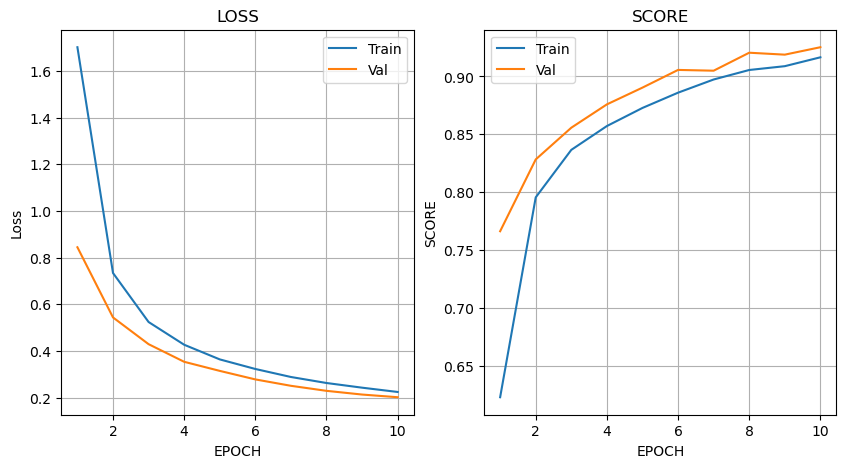

In [82]:
# 학습 후 LOSS 시각화
TH = len(loss_history[0])
fg, axes = plt.subplots(1,2, figsize=(10,5), sharex=True)

axes[0].plot(range(1,TH+1),loss_history[0][:TH], label='Train')
axes[0].plot(range(1,TH+1),loss_history[1][:TH], label='Val')
# axes[0].plot(range(1,TH+1),loss_history[2][:TH], label='Test')
axes[0].grid('--')
axes[0].legend()
axes[0].set_xlabel('EPOCH')
axes[0].set_ylabel('Loss')
axes[0].set_title('LOSS')

axes[1].plot(range(1,TH+1),f1score_history[0][:TH], label='Train')
axes[1].plot(range(1,TH+1),f1score_history[1][:TH], label='Val')
# axes[1].plot(range(1,TH+1),f1score_history[2][:TH], label='Test')
axes[1].grid('--')
axes[1].legend()
axes[1].set_xlabel('EPOCH')
axes[1].set_ylabel('SCORE')
axes[1].set_title('SCORE')
plt.show()